In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar

In [2]:
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
v_max = 8
z_max = 0.020/x0
z_start = 0.020/x0
dz = 0.0005/x0
dv = 0.0005
v_eval = np.arange(1.0,4.0,0.5)
t_eval = np.linspace(0.,3000000.,3000001)
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

# The detunings used in the PRAs:
P = np.array([0.010, 0.050, 0.1, 0.2])
intensities = 2.*P/(np.pi*(0.012)**2)/Isat
power_index = 2

#Make the axis:
zz = np.linspace(-1*z_max,z_max+dz,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)



H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [3]:
def Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    pX = (p1+p2+p3+p4)/4
    pp1 = p1 - pX
    pp2 = p2 - pX
    pp3 = p3- pX
    pp4 = p4 - pX
    
    def intensity_res(pp):
        intensity_norm = 0.050
        result = 2.*(intensity_norm+pp/(10**3))/(np.pi*(0.012)**2)/Isat
        return result
    
    def sigmoid_function(x):
        if (1/(1+np.exp(-1*x))*2)//1 == 1.:
            return +1
        else:
            return -1
    
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp1), delta=(E_A[-1] - Eg_i)+d1,pol=sigmoid_function(pol1),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp2), delta=(E_A[-1] - Eg_i)+d2,pol=sigmoid_function(pol2),wb=waist,
                beam_type=pylcp.gaussianBeam)
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp3), delta=(E_A[-1] - Eg_i)+d3,pol=sigmoid_function(pol3),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp4), delta=(E_A[-1] - Eg_i)+d4,pol=sigmoid_function(pol4),wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [4]:
def vc_bayesian(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*1000*x0)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0s,v0s,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA')
    sol = eqn.sol
    
    if abs(sol.r[0][-1])*1000*x0<5 and abs(sol.r[1][-1])*1000*x0<5 and abs(sol.v[0][-1])<5e-2 and abs(sol.v[1][-1])<5e-2:
        return v0s
    else:
        return -1.

In [5]:
start = time.time()

print(vc_bayesian(2.5,1,-0.4,0.1,-1.7,-2.8,5,21,28,26,-1,-1,1,-1))  

print(time.time()-start)

-1.0
8.6412672996521


In [6]:
pbounds = {'v0s':(2,8),'Bgrad':(0.1,2),'d1':(-3,1),'d2':(-3,1),'d3':(-3,1),'d4':(-3,1),'p1':(0,50),'p2':(0,50),'p3':(0,50),'p4':(0,50),'pol1':(-1,1),'pol2':(-1,1),'pol3':(-1,1),'pol4':(-1,1)}

In [7]:
optimizer = BayesianOptimization(
    f = vc_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [ ]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

In [8]:
from bayes_opt.util import load_logs

# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["./logs.json"])

In [9]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs.json',reset=False)
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [10]:
start = time.time()
optimizer.maximize(
    init_points=30,
    n_iter=100,)
print(time.time()-start)

1573.2437925338745


In [11]:
import pprint

In [12]:
pprint.pprint(optimizer.max)

{'params': {'Bgrad': 1.2528168984164048,
            'd1': -2.5199775899908197,
            'd2': 0.22773582325913377,
            'd3': -0.6681841482979487,
            'd4': -0.4729265546420556,
            'p1': 15.499490198498794,
            'p2': 20.486544283932638,
            'p3': 23.168825254769747,
            'p4': 21.018278114257004,
            'pol1': -0.7070729036856251,
            'pol2': -0.22622612784360263,
            'pol3': 0.8451169581057016,
            'pol4': 0.9480729825079086,
            'v0s': 5.810551547481607},
 'target': 5.810551547481607}


In [13]:
optimizer.res[0]

{'target': -1.0,
 'params': {'Bgrad': 0.8923418089348906,
  'd1': -0.11870202623136761,
  'd2': -2.9995425007306205,
  'd3': -1.790669709472641,
  'd4': -2.412976436731548,
  'p1': 4.6169297384398895,
  'p2': 9.313010568883545,
  'p3': 17.278036352152387,
  'p4': 19.838373711533496,
  'pol1': 0.07763346800671389,
  'pol2': -0.1616109711934104,
  'pol3': 0.370439000793519,
  'pol4': -0.5910955005369651,
  'v0s': 7.268704618345673}}

In [14]:
vc_bayesian(**optimizer.max['params'])

5.810551547481607

In [15]:
def ploting_function(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*1000*x0)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,0,0]),np.array([v0s,0,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA')
    
    fig,ax = plt.subplots(1,1,figsize=(13,7))
    
    imz = ax.imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax)
    cbz.set_label('$a (\mathrm{km/s^2})$')
    ax.set_xlabel('$x (\mathrm{mm})$')
    ax.set_ylabel('$v (\mathrm{m/s})$')
    ax.set_title('X axis force image')
    ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    ax.plot(eqn.sol.r[0]*x0*1000,eqn.sol.v[0]*v0,'k') 
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    fig.savefig('./MOT/optimized')
    

In [16]:
def ploting_function_2(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    v_list = np.linspace(v0s-2,v0s+2,11)
    sols_list = list()
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*1000*x0)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)


    
    for v0ss in v_list:
        eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0ss,v0ss,1]))
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

        eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 1,method='LSODA')
        sols_list.append(eqn.sol)
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')
    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*v_max*v0,1*v_max*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    for sol in sols_list:
        ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0)
        ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0)
        ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0)
        print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
#     fig.savefig('./MOT/optimized_xy')
    

Completed in 20.74 s.                                               
Completed in 21.34 s.                                               
Completed in 25.40 s.                                               
Completed in 4.93 s.                                                    
Completed in 6.97 s.                                                    
Completed in 7.04 s.                                                    
Completed in 6.71 s.                                                    
Completed in 6.87 s.                                                    
Completed in 6.89 s.                                                    
Completed in 8.98 s.                                                    
Completed in 10.19 s.                                                   
Completed in 12.65 s.                                                   
Completed in 11.35 s.                                                   
Completed in 13.88 s.                                          

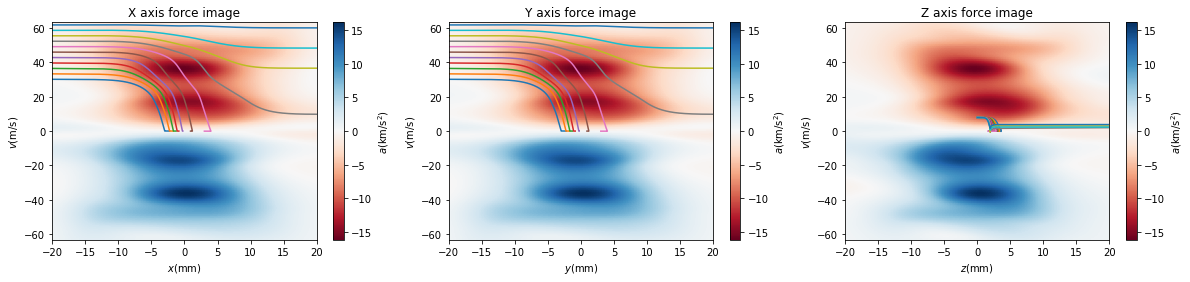

In [17]:
ploting_function_2(**optimizer.max['params'])

In [18]:
optimizer.max['params']

{'Bgrad': 1.2528168984164048,
 'd1': -2.5199775899908197,
 'd2': 0.22773582325913377,
 'd3': -0.6681841482979487,
 'd4': -0.4729265546420556,
 'p1': 15.499490198498794,
 'p2': 20.486544283932638,
 'p3': 23.168825254769747,
 'p4': 21.018278114257004,
 'pol1': -0.7070729036856251,
 'pol2': -0.22622612784360263,
 'pol3': 0.8451169581057016,
 'pol4': 0.9480729825079086,
 'v0s': 5.810551547481607}

In [19]:
3e6*t0

0.02170294678525846

In [20]:
1e5*x0

0.0057184371052918